# Trabajo 2 - IA

Resumen aqui


In [110]:
!pip install imblearn
!pip install scikeras

In [185]:
import kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# supervised
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, InputLayer
from scikeras.wrappers import KerasClassifier

# unsupervised
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# custom transformers

from sklearn.base import BaseEstimator, TransformerMixin

# balanceo

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from itertools import product
from tqdm.notebook import tqdm

# warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [21]:
path = kagglehub.dataset_download("therohithanand/used-car-price-prediction", path="used_car_price_dataset_extended.csv")

raw_df = pd.read_csv(path)
raw_df = raw_df.reset_index(drop=True)

### Limpiando el Dataframe

In [22]:
df = raw_df.copy()
df = df.drop(columns=['color', 'service_history'])
df.head()

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,accidents_reported,insurance_valid
0,2001,8.17,4000,Petrol,4,8587.64,Chevrolet,Manual,0,No
1,2014,17.59,1500,Petrol,4,5943.50,Honda,Manual,0,Yes
2,2023,18.09,2500,Diesel,5,9273.58,BMW,Automatic,1,Yes
3,2009,11.28,800,Petrol,1,6836.24,Hyundai,Manual,0,Yes
4,2005,12.23,1000,Petrol,2,4625.79,Nissan,Automatic,0,Yes


Se verifica si la variable respuesta es normal o no para elegir el método de balanceo de datos

<Axes: >

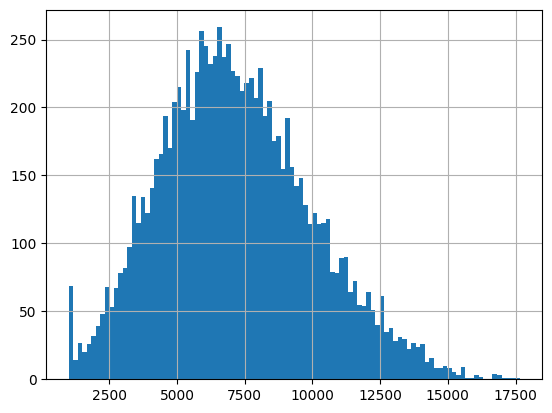

In [23]:
df['price_usd'].hist(bins=100)

In [24]:
# Ejecutar la prueba de Shapiro-Wilk
stat, p_value = shapiro(df['price_usd'])

# Mostrar resultados
print(f'Estadístico W: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
if p_value > 0.05:
    print("Parece una distribución normal (no se rechaza H0)")
else:
    print("No parece una distribución normal (se rechaza H0)")

Estadístico W: 0.9907063127964498
Valor p: 5.045010001757705e-25
No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


In [25]:
cols_priority = (df.corr(numeric_only=True).abs()['price_usd'].sort_values(ascending=False)).index[1:]
print(cols_priority.values)

['engine_cc' 'make_year' 'owner_count' 'mileage_kmpl' 'accidents_reported']


In [26]:
df['price_usd'].value_counts(bins=4).sort_index()

,count
"(983.351, 5161.908]",2478
"(5161.908, 9323.815]",5365
"(9323.815, 13485.722]",1960
"(13485.722, 17647.63]",197


<Axes: >

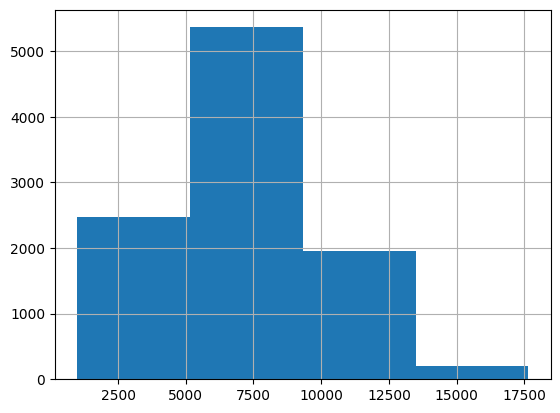

In [27]:
df['price_usd'].hist(bins=4)

In [28]:
#Mapea los categorias
#Convierte todo a categorias en vez de objetos
categorical_cols = df.select_dtypes(include='object').columns

df[categorical_cols] = df[categorical_cols].astype('category')

# convierte la variable objetivo a categorica
labels = ['Very Low', 'Low', 'Moderate', 'High']
df['price_usd'] = pd.cut(df['price_usd'], bins=4, labels=labels, include_lowest=True)

#Insertar variable dependiente de primero por comodidad
price_serie = df['price_usd']
df = df.drop(columns=['price_usd'])
df.insert(0, 'price_usd', price_serie)

df.head()


,price_usd,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,brand,transmission,accidents_reported,insurance_valid
0,Low,2001,8.17,4000,Petrol,4,Chevrolet,Manual,0,No
1,Low,2014,17.59,1500,Petrol,4,Honda,Manual,0,Yes
2,Low,2023,18.09,2500,Diesel,5,BMW,Automatic,1,Yes
3,Low,2009,11.28,800,Petrol,1,Hyundai,Manual,0,Yes
4,Very Low,2005,12.23,1000,Petrol,2,Nissan,Automatic,0,Yes


<Axes: xlabel='price_usd', ylabel='count'>

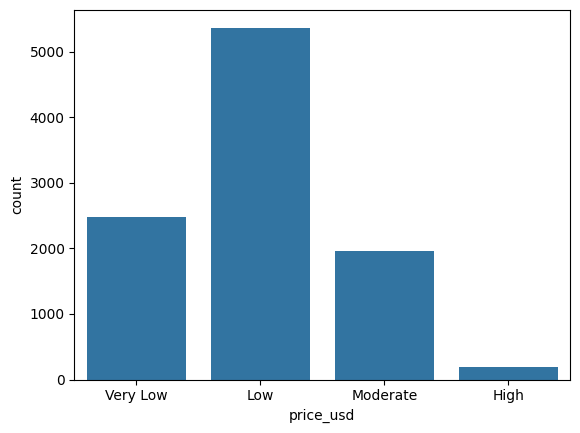

In [29]:
sns.countplot(x='price_usd', data=df, order=labels)

## Preprocesamiento

In [56]:
class OutliersHandler(BaseEstimator, TransformerMixin):
    """
    Transformer personalizado para el manejo de outliers en conjuntos de datos numéricos.

    Este transformador permite dos modos de operación:
    - Eliminación de outliers usando el criterio del rango intercuartílico (IQR).
    - Generación de outliers sintéticos para asegurar que representen el 5% del total del dataset.

    Parámetros
    ----------
    make_outliers : bool, default=False
        Si es True, se generarán outliers sintéticos en lugar de eliminarlos.
    """
    def __init__(self, make_outliers = False):
        self.column_name = ""
        self.make_outliers = make_outliers

    def fit(self, X, y=None):
        return self  # The fit method typically does nothing for transformers

    def transform(self, X):
        # Your transformation logic goes here
        X_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
        X_transformed = self._make_outliers(X_transformed) if self.make_outliers else self._delete_outliers(X_transformed)

        return X_transformed

    # Elimina las filas, donde uno de los valores numericos este fuera de los intervalos
    def _delete_outliers(self, df: pd.DataFrame):
        float_cols = df.select_dtypes('float64').columns

        for col in float_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)

            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        return df

    def _make_outliers(self, df: pd.DataFrame, random_state: int = 42) -> pd.DataFrame:
        """
        A partir del df original, detecta sus outliers y genera (replicándolos
        y añadiendo un pequeño ruido) tantas tuplas como hagan falta para que
        los outliers representen el 5% del total.

        Parámetros:
        - df: DataFrame de entrada.
        - random_state: semilla para la aleatoriedad.

        Retorna:
        - DataFrame con 5% outliers o sin outliers.
        """
        float_cols = df.select_dtypes(include='float64').columns

        outlier_mask = pd.Series(False, index=df.index)
        for col in float_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outlier_mask |= (df[col] < lower) | (df[col] > upper)

        outliers = df[outlier_mask]
        non_outliers = df[~outlier_mask]

        total_orig = len(df)
        n_outliers = len(outliers)
        target_outliers = int(np.floor(0.05 * total_orig))

        # Si hay menos outliers que el 5%, generamos más
        needed = target_outliers - n_outliers
        synth = outliers.sample(n=needed, replace=True, random_state=random_state)
        # Clonamos los outliers existentes pero les añadimos  ruido
        for col in float_cols:
            sigma = df[col].std() * 0.01
            synth[col] = synth[col] + np.random.RandomState(random_state).normal(0, sigma, size=needed)
        result = pd.concat([df, synth], ignore_index=True)

        return result


In [190]:
def outliers_maker(data, make_outliers = False):
    outliers = OutliersHandler(make_outliers=make_outliers)
    return outliers.fit_transform(data)

def scaler(X_train, X_test, columns):
    # fit_transform en X_train y transform en X_test
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    std_scaler = StandardScaler()

    X_train_scaled[columns] = std_scaler.fit_transform(X_train[columns])
    X_test_scaled[columns] = std_scaler.transform(X_test[columns])

    return X_train_scaled, X_test_scaled

def X_encoder(X_train : pd.DataFrame, X_test : pd.DataFrame, columns : str):
    # para X_train y X_test (despues de escalar)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    oh_enc = OneHotEncoder(sparse_output=False)

    # aplicar one_hot
    X_train_cat = oh_enc.fit_transform(X_train[columns])
    X_test_cat = oh_enc.transform(X_test[columns])

    # Get feature names for the encoded columns
    encoded_cat_features = oh_enc.get_feature_names_out(columns)

    # Create DataFrames from encoded arrays
    X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=encoded_cat_features)
    X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test.index, columns=encoded_cat_features)

    # juntar columnas con one_hot con el resto del dataframe
    X_train_encoded = X_train_encoded.drop(columns = columns)
    X_test_encoded = X_test_encoded.drop(columns = columns)
    X_train_encoded = X_train_encoded.join(X_train_cat_df)
    X_test_encoded = X_test_encoded.join(X_test_cat_df)

    return X_train_encoded, X_test_encoded

def y_encoder(y):
    ord_enc = OrdinalEncoder(categories=[['Very Low', 'Low', 'Moderate', 'High']])

    y_encoded = pd.DataFrame(y)

    # aplicar ordinal_enc
    y_encoded = ord_enc.fit_transform(y_encoded)

    # print({i: cat for i, cat in enumerate(list(ord_enc.categories_[0]))})

    return y_encoded

def balancer(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)

def build_model(meta, layer1_size=16, layer2_size=8, activation='relu', optimizer='SGD', input_shape=None):
    model = Sequential()
    model.add(Dense(layer1_size, activation=activation, input_dim=meta["n_features_in_"]))
    model.add(Dense(layer2_size, activation=activation))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model(input_dim):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),  # Sin advertencia de depreciación
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [193]:
def pipeline_maker(dataframe : pd.DataFrame, model : str, y_label : str = 'price_usd', make_outliers = False, balance = False, scale = False):
    data = dataframe.copy()

    # hacer outliers
    if make_outliers == True:
        data = outliers_maker(data, make_outliers=True)
    else:
        data = outliers_maker(data, make_outliers=False)

    # Encode target variable
    y = y_encoder(data[y_label])
    X = data.drop(columns=[y_label])

    # lista donde se almacenarán los steps a usar
    steps = []

    cat_features = X.select_dtypes(include='category').columns
    num_features = X.select_dtypes(include='number').columns

    # escalado de datos
    if scale:
        col_transformer = ColumnTransformer([
            ('std_scaler', StandardScaler(), num_features),
            ('one_hot', OneHotEncoder(), cat_features)
        ])
    else: # en caso de no escalar
        col_transformer = ColumnTransformer([
            ('one_hot', OneHotEncoder(), cat_features)
        ])
    steps.append(('preprocessor', col_transformer))

    # balanceo con smote
    if balance:
        steps.append(
            ('smote', SMOTE(random_state=42))
            )

    X_transformed = col_transformer.fit_transform(X.head(1))  # Muestra representativa

    # seleccion de modelo
    if model == 'svm':
        steps.append(
            ('SVC', SVC(random_state=42))
        )
    elif model == 'knn':
        steps.append(
            ('knn', KNeighborsClassifier())
        )
    elif model == 'tree':
        steps.append(
            ('decision_tree', DecisionTreeClassifier(random_state=42))
        )

    elif model == 'nn':
        model = KerasClassifier(
            model=lambda: create_model(input_dim),  # IMPORTANTE: función lambda
            epochs=10,
            batch_size=32,
            verbose=2
        )

        steps.append(('neural_network', model))
    elif model == 'kmeans':
        steps.append(
            ('kmeans', KMeans())
        )
    elif model == 'dbscan':
        steps.append(
            ('dbscan', DBSCAN())
        )
    else:
        raise ValueError("Ingrese uno de los siguientes: 'svm', 'knn', 'tree', 'nn', 'kmeans', 'dbscan'")


    pipeline = imbPipeline(steps)

    return X, y, pipeline

## 2. Aprendizaje Supervisado

### 2.2. Entrenamiento con Árboles, KNN, SVM, y Redes Neuronales.

In [137]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#### 2.2.1 KNN

In [138]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
knn_info = []

for combo in tqdm(product([True, False], repeat=3), total = 8):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'knn',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Definimos los hiperparámetros a explorar con RandomizedSearchCV
    param_dist = {
        'knn__n_neighbors': list(range(2, 30))  # número de vecinos para el clasificador KNN
    }

    # Búsqueda aleatoria de hiperparámetros con validación cruzada 5-fold
    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,  # Número de combinaciones aleatorias a evaluar
        cv=5,  # Validación cruzada de 5 folds
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],  # Métricas a evaluar
        refit='f1_macro',  # Se selecciona como mejor modelo el que tenga mejor f1_macro
        verbose=1,
        random_state=42
    )

    # Entrenamos el modelo con los datos de entrenamiento
    grid.fit(X_train, y_train.ravel())

    # Mostramos los mejores parámetros y el mejor score obtenido en validación cruzada
    print("Mejores parámetros encontrados:", grid.best_params_)
    print(f"Mejor score CV: {grid.best_score_:.3f}")

    # Se predice sobre el conjunto de prueba
    y_pred = grid.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    knn_info.append(my_model_info)


  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [75]:
knn_info

[{'best_params': {'knn__n_neighbors': 14},
  'best_model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('std_scaler',
                                                    StandardScaler(),
                                                    Index(['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count',
         'accidents_reported'],
        dtype='object')),
                                                   ('one_hot', OneHotEncoder(),
                                                    Index(['fuel_type', 'brand', 'transmission', 'insurance_valid'], dtype='object'))])),
                  ('smote', SMOTE(random_state=42)),
                  ('knn', KNeighborsClassifier(n_neighbors=14))]),
  'metrics': {'accuracy': 0.7104634495938844,
   'precision': 0.6264016360618314,
   'recall': 0.7477271952259164,
   'f1': 0.6592213859355807},
  'dataset_info': {'make_outliers': True, 'balance': True, 'scale': True}},
 {'best_params': {'knn__n_neighbors': 2

#### 2.2.2. SVM

In [81]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
svm_info = []

for combo in tqdm(product([True, False], repeat=3), total=8):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'svm',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Definimos los hiperparámetros a explorar con RandomizedSearchCV
    param_dist = {
        'SVC__C': np.logspace(-3, 0, num = 10),
        'SVC__kernel': ['linear', 'rbf', 'poly'],
        'SVC__gamma': np.logspace(-2, 0, num = 10)
    }

    # Búsqueda aleatoria de hiperparámetros con validación cruzada 5-fold
    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=5,  # Número de combinaciones aleatorias a evaluar
        cv=5,  # Validación cruzada de 5 folds
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],  # Métricas a evaluar
        refit='f1_macro',  # Se selecciona como mejor modelo el que tenga mejor f1_macro
        verbose=1,
        random_state=42
    )

    # Entrenamos el modelo con los datos de entrenamiento
    grid.fit(X_train, y_train.ravel())

    # Mostramos los mejores parámetros y el mejor score obtenido en validación cruzada
    print("Mejores parámetros encontrados:", grid.best_params_)
    print(f"Mejor score CV: {grid.best_score_:.3f}")

    # Se predice sobre el conjunto de prueba
    y_pred = grid.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    svm_info.append(my_model_info)


  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.3593813663804626), 'SVC__C': np.float64(0.1)}
Mejor score CV: 0.736
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.5994842503189409), 'SVC__C': np.float64(0.46415888336127775)}
Mejor score CV: 0.316
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.3593813663804626), 'SVC__C': np.float64(0.1)}
Mejor score CV: 0.747
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.3593813663804626), 'SVC__C': np.float64(0.1)}
Mejor score CV: 0.238
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.3593813663804626), 'SVC__C': np.float64(0.1)}
Mejor score CV: 0.722
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.5994842503189409), 'SVC__C': np.float64(0.46415888336127775)}
Mejor score CV: 0.270
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.3593813663804626), 'SVC__C': np.float64(0.1)}
Mejor score CV: 0.736
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mejores parámetros encontrados: {'SVC__kernel': 'poly', 'SVC__gamma': np.float64(0.5994842503189409), 'SVC__C': np.float64(0.46415888336127775)}
Mejor score CV: 0.223


In [147]:
svm_info

[{'best_params': {'SVC__kernel': 'poly',
   'SVC__gamma': np.float64(0.3593813663804626),
   'SVC__C': np.float64(0.1)},
  'best_model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('std_scaler',
                                                    StandardScaler(),
                                                    Index(['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count',
         'accidents_reported'],
        dtype='object')),
                                                   ('one_hot', OneHotEncoder(),
                                                    Index(['fuel_type', 'brand', 'transmission', 'insurance_valid'], dtype='object'))])),
                  ('smote', SMOTE(random_state=42)),
                  ('SVC',
                   SVC(C=np.float64(0.1), gamma=np.float64(0.3593813663804626),
                       kernel='poly', random_state=42))]),
  'metrics': {'accuracy': 0.8069756330625896,
   'precision': 0.7380197148649381,
  

#### 2.2.3. Decision Trees

In [105]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
tree_info = []

for combo in tqdm(product([True, False], repeat=3), total=8):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'tree',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Definimos los hiperparámetros a explorar con RandomizedSearchCV
    param_dist = {
        'decision_tree__max_depth': [None, 5, 10, 15, 20],
        'decision_tree__min_samples_split': [2, 5, 10],
        'decision_tree__min_samples_leaf': [1, 2, 4],
        'decision_tree__max_features': [None, 'sqrt', 'log2']
    }

    # Búsqueda aleatoria de hiperparámetros con validación cruzada 5-fold
    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,  # Número de combinaciones aleatorias a evaluar
        cv=10,  # Validación cruzada de 10 folds
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],  # Métricas a evaluar
        refit='f1_macro',  # Se selecciona como mejor modelo el que tenga mejor f1_macro
        verbose=1,
        random_state=42
    )

    # Entrenamos el modelo con los datos de entrenamiento
    grid.fit(X_train, y_train.ravel())

    # Mostramos los mejores parámetros y el mejor score obtenido en validación cruzada
    print("Mejores parámetros encontrados:", grid.best_params_)
    print(f"Mejor score CV: {grid.best_score_:.3f}")

    # Se predice sobre el conjunto de prueba
    y_pred = grid.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    tree_info.append(my_model_info)


  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores parámetros encontrados: {'decision_tree__min_samples_split': 10, 'decision_tree__min_samples_leaf': 4, 'decision_tree__max_features': None, 'decision_tree__max_depth': 10}
Mejor score CV: 0.704
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores parámetros encontrados: {'decision_tree__min_samples_split': 10, 'decision_tree__min_samples_leaf': 4, 'decision_tree__max_features': 'sqrt', 'decision_tree__max_depth': 15}
Mejor score CV: 0.322
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores parámetros encontrados: {'decision_tree__min_samples_split': 10, 'decision_tree__min_samples_leaf': 4, 'decision_tree__max_features': None, 'decision_tree__max_depth': 10}
Mejor score CV: 0.714
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores parámetros encontrados: {'decision_tree__min_samples_split': 2, 'decision_tree__min_samples_leaf': 4, 'decision_tree__max_features':

In [148]:
tree_info

[{'best_params': {'decision_tree__min_samples_split': 10,
   'decision_tree__min_samples_leaf': 4,
   'decision_tree__max_features': None,
   'decision_tree__max_depth': 10},
  'best_model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('std_scaler',
                                                    StandardScaler(),
                                                    Index(['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count',
         'accidents_reported'],
        dtype='object')),
                                                   ('one_hot', OneHotEncoder(),
                                                    Index(['fuel_type', 'brand', 'transmission', 'insurance_valid'], dtype='object'))])),
                  ('smote', SMOTE(random_state=42)),
                  ('decision_tree',
                   DecisionTreeClassifier(max_depth=10, min_samples_leaf=4,
                                          min_samples_split=10,
                   

#### 2.2.4. Neural Networks

In [194]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
nn_info = []

for combo in tqdm(product([True, False], repeat=3), total=8):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = True #combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'nn',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Definimos los hiperparámetros a explorar con RandomizedSearchCV
    param_dist = {
        'neural_network__model__layer1_size': [16, 32, 64],
        'neural_network__model__activation': ['relu', 'tanh'],
        'neural_network__optimizer': ['adam', 'sgd'],
        'neural_network__epochs': [10, 20],
        'neural_network__batch_size': [16, 32]
    }

    # # Búsqueda aleatoria de hiperparámetros con validación cruzada 5-fold
    # grid = RandomizedSearchCV(
    #     pipeline,
    #     param_distributions=param_dist,
    #     n_iter=2,  # Número de combinaciones aleatorias a evaluar
    #     cv=3,  # Validación cruzada de 5 folds
    #     scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],  # Métricas a evaluar
    #     refit='f1_macro',  # Se selecciona como mejor modelo el que tenga mejor f1_macro
    #     verbose=3,
    #     random_state=42
    # )
    grid = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=3,
        cv=3,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        refit='f1_macro',
        verbose=3,
        n_jobs=1,  # Reduce a 1 job para mejor diagnóstico
        error_score='raise'  # Para ver errores inmediatos
    )

    # Entrenamos el modelo con los datos de entrenamiento
    grid.fit(X_train, y_train.ravel())

    # Mostramos los mejores parámetros y el mejor score obtenido en validación cruzada
    print("Mejores parámetros encontrados:", grid.best_params_)
    print(f"Mejor score CV: {grid.best_score_:.3f}")

    # Se predice sobre el conjunto de prueba
    y_pred = grid.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    nn_info.append(my_model_info)


  0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


TypeError: create_model() got an unexpected keyword argument 'layer1_size'

In [184]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
nn_info = []

for combo in tqdm(product([True, False], repeat=3), total=8):  # tqdm muestra una barra de progreso
    make_outliers = combo[0]
    balance = combo[1]
    scale = True #combo[2]

    # Se construye el conjunto de datos y pipeline de preprocesamiento+modelo según las opciones indicadas
    X, y, pipeline = pipeline_maker(df, 'nn',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # Se divide el dataset en entrenamiento y prueba con estratificación para mantener la proporción de clases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    pipeline.fit(X_train,y_train)

    # Se predice sobre el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Se guarda la información relevante del modelo en un diccionario
    my_model_info = {
        'best_params': grid.best_params_,  # Hiperparámetros óptimos encontrados
        'best_model': grid.best_estimator_,  # Pipeline completo con mejores hiperparámetros
        'metrics': {  # Métricas de desempeño sobre el conjunto de prueba
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {  # Información sobre la configuración de preprocesamiento
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    # Agregamos la información del modelo a la lista de resultados
    nn_info.append(my_model_info)

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [195]:
# Lista para almacenar información sobre cada configuración de modelo evaluada
nn_info = []

for combo in tqdm(product([True, False], repeat=3), total=8):
    make_outliers = combo[0]
    balance = combo[1]
    scale = True  # Fijo en True según tu código

    # Construir pipeline (asegúrate de que pipeline_maker usa KerasClassifier de scikeras)
    X, y, pipeline = pipeline_maker(df, 'nn',
                                    make_outliers=make_outliers,
                                    balance=balance,
                                    scale=scale)

    # División del dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Entrenamiento y predicción
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)  # Error resuelto aquí

    # Guardar información relevante (sin grid)
    my_model_info = {
        'metrics': {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro')
        },
        'dataset_info': {
            'make_outliers': make_outliers,
            'balance': balance,
            'scale': scale
        }
    }

    nn_info.append(my_model_info)

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_440" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None

In [196]:
from itertools import product
from tqdm import tqdm

nn_info = []

for combo in tqdm(product([True, False], repeat=3), total=8):
    make_outliers = combo[0]
    balance = combo[1]
    scale = True  # Fijo según tu código

    try:
        X, y, pipeline = pipeline_maker(
            df, 'nn',
            make_outliers=make_outliers,
            balance=balance,
            scale=scale
        )

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        nn_info.append({
            'metrics': {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall': recall_score(y_test, y_pred, average='macro'),
                'f1': f1_score(y_test, y_pred, average='macro')
            },
            'dataset_info': {
                'make_outliers': make_outliers,
                'balance': balance,
                'scale': scale
            }
        })

    except Exception as e:
        print(f"Error con combo {combo}: {str(e)}")
        continue

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

Error con combo (True, True, True): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_442" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 25%|██▌       | 2/8 [00:01<00:03,  1.97it/s]

Error con combo (True, True, False): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_444" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 38%|███▊      | 3/8 [00:01<00:01,  2.52it/s]

Error con combo (True, False, True): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_446" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 50%|█████     | 4/8 [00:01<00:01,  2.42it/s]

Error con combo (True, False, False): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_448" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 62%|██████▎   | 5/8 [00:02<00:01,  2.42it/s]

Error con combo (False, True, True): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_450" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 75%|███████▌  | 6/8 [00:02<00:00,  2.50it/s]

Error con combo (False, True, False): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_452" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
 88%|████████▊ | 7/8 [00:02<00:00,  2.53it/s]

Error con combo (False, False, True): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_454" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

Error con combo (False, False, False): Exception encountered when calling Sequential.call().

Input 0 of layer "dense_456" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 22)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 22), dtype=float32)
  • training=True
  • mask=None
